In [10]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from utils.dataset import ChestImage64
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, DataLoader

In [1]:
csv_path = '../Data/64px Images/train_labels_64p.csv'
root_path = '../Data/64px Images'

In [2]:
transform = Compose([
    Resize((64, 64)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
dataset = ChestImage64(csv_path=csv_path, root_path=root_path, class_name="Frontal", transform=transform)

In [4]:

train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = int(0.2 * len(dataset))

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


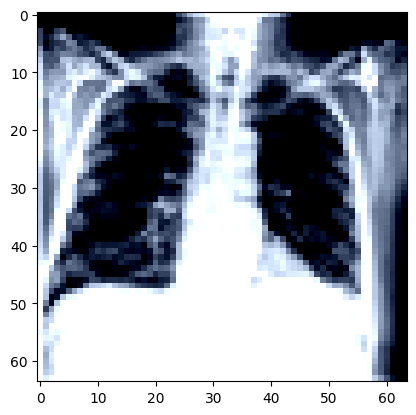

1


In [17]:
for item in train_loader:
    image = item[0][0].numpy()/2 + 0.5
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.show()
    print(item[1][0].item())
    break

In [22]:
import torch
output = torch.tensor([[0.3592],
        [0.3906],
        [0.4108],
        [0.4037],
        [0.3832],
        [0.3800],
        [0.3862],
        [0.4282],
        [0.3844]])
target = torch.tensor([[0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0]],dtype=torch.float32)


In [26]:
torch.nn.functional.cross_entropy(torch.tensor([2.0]),torch.tensor([0.0]))

tensor(-0.)

In [27]:
import torch
import torch.nn as nn

# Define the input (logits) and target (ground truth labels)
logits = torch.randn(3, 5) # A batch of 3 samples with 5 classes
target = torch.tensor([1, 0, 3]) # Ground truth labels for each sample

# Create the CrossEntropyLoss object
criterion = nn.CrossEntropyLoss()

# Calculate the loss
loss = criterion(logits, target)


In [28]:
loss

tensor(1.7975)

In [29]:
logits

tensor([[-0.2047, -0.2432,  0.0916, -1.3347, -0.2571],
        [-0.4409, -1.9981,  0.5317,  1.0099, -1.0528],
        [-0.7982,  1.0698, -0.2571,  0.1007, -0.4305]])

In [1]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=3,
                 dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)


# %%
torch.manual_seed(42)
import torchvision

## define the data
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from utils.dataset import ChestImage64
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, DataLoader

from torchvision.datasets import MNIST

csv_path = '../Data/64px Images/train_labels_64p.csv'
root_path = '../Data/64px Images'
transform = Compose([
    Resize((64, 64)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = ChestImage64(csv_path=csv_path, root_path=root_path, class_name="Frontal", transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = int(0.2 * len(dataset))

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

from torch import optim
import torch.nn.functional as F
import time

model = ViT(image_size=64, patch_size=8, num_classes=2, channels=3, dim=128, depth=4, heads=8, mlp_dim=128)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
# %%
sum(p.numel() for p in model.parameters())


# %%
def train_epoch(model, optimizer, data_loader, loss_history, device):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()

        output = model(data)

        loss = F.cross_entropy(output, target)

        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' + '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())


# %%
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

N_EPOCHS = 3

start_time = time.time()

model.to(device)

train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history, device)
    # evaluate(model, test_loader, test_loss_history, device)

Epoch: 1
[    0/21441 (  0%)]  Loss: 0.9781
[ 3200/21441 ( 15%)]  Loss: 0.5471
[ 6400/21441 ( 30%)]  Loss: 0.6728
[ 9600/21441 ( 45%)]  Loss: 0.4122
[12800/21441 ( 60%)]  Loss: 0.6007
[16000/21441 ( 75%)]  Loss: 0.5338
[19200/21441 ( 89%)]  Loss: 0.5786
Epoch: 2
[    0/21441 (  0%)]  Loss: 0.4377
[ 3200/21441 ( 15%)]  Loss: 0.4756
[ 6400/21441 ( 30%)]  Loss: 0.7012
[ 9600/21441 ( 45%)]  Loss: 0.4432
[12800/21441 ( 60%)]  Loss: 0.4515
[16000/21441 ( 75%)]  Loss: 0.5790
[19200/21441 ( 89%)]  Loss: 0.5571
Epoch: 3
[    0/21441 (  0%)]  Loss: 0.4466
[ 3200/21441 ( 15%)]  Loss: 0.4064
[ 6400/21441 ( 30%)]  Loss: 0.5356
[ 9600/21441 ( 45%)]  Loss: 0.4525
[12800/21441 ( 60%)]  Loss: 0.5046
[16000/21441 ( 75%)]  Loss: 0.5827
[19200/21441 ( 89%)]  Loss: 0.5331


In [2]:
num_correct = 0
total_samples = 0
with torch.no_grad():
    for data, labels in test_loader:
        # Get the model's output logits
        logits = model(data)

        # Convert the logits to class predictions
        _, predictions = torch.max(logits, dim=1)

        # Calculate the number of correct predictions
        num_correct += torch.sum(predictions == labels).item()
        total_samples += labels.size(0)

# Calculate the accuracy
accuracy = num_correct / total_samples

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 76.48%
